# <center>Insurance Cost Prediction</center>

**Business Problem:** An insurance company wants to automate the process of charging the patients with insurance amount based on their demographic, behavorial and region data.</br>
**Objective:** To predict the insurance charges the patient has to pay based on their age, sex, number of children they have, whether they smoke or not and the region where they live.</br>
**Approach:** Performed EDA uncovering the relationship between different variables. Found which variables are most correlated with the target variable i.e. charges. Fit Linear Regression, Decision Trees and Random Forest models to the data to choose the best performing model. Used GridSearchCV to select the best parameters for Random Forest Regressor.</br>

In [1]:
# Import the necessary libraries

# Libraries for data analysis
import numpy as np
import pandas as pd

# Libraries for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For encoding the categorical variables to numerical
from sklearn.preprocessing import LabelEncoder

# Libraries for modeling the data
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from sklearn.model_selection import GridSearchCV

## Exploratory Data Analysis:

In [2]:
# Read the data
insurance = pd.read_csv('insurance.csv')

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# Getting a gist of the data
insurance.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [6]:
# Checking if there are any missing values
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
categorical_cols = list(insurance.select_dtypes(include='object').columns)
categorical_cols

['sex', 'smoker', 'region']

In [8]:
# Distribution of male and females in the dataset
insurance.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

Distribution of male and female patients in the dataset is almost equal.

In [9]:
# Distribution of smokers and non-smokers in the dataset
insurance.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

The number of patients not smoking is very less as compared to those who smoke.

In [10]:
insurance.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

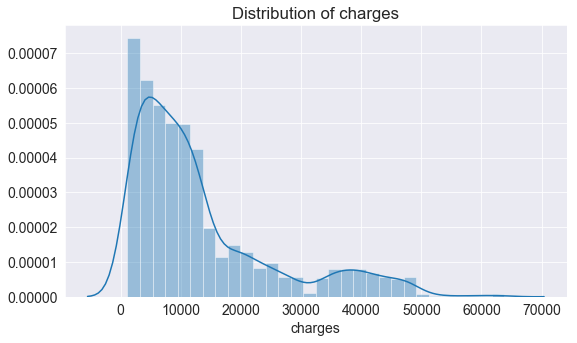

In [11]:
# Plotting the distribution of charges column
sns.set_style("darkgrid")
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
plt.title("Distribution of charges")
sns.distplot(insurance.charges)

Distribution of the insurance charges is **Right Skewed** or we can say it has **Positive Skewness**.

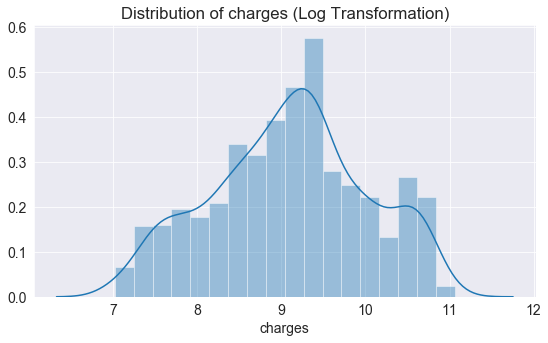

In [12]:
# Plotting the distribution of charges column by using log transformation to reduce skewness
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
plt.title("Distribution of charges (Log Transformation)")
sns.distplot(np.log(insurance.charges))

Text(0.5, 1.0, 'Charges Frequency Distribution')

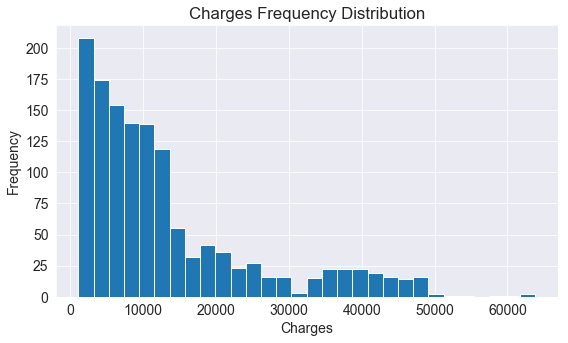

In [13]:
# Frequency distribution of charges column using matplotlib
plt.hist(x=insurance.charges, bins='auto')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charges Frequency Distribution')

### Label Encoding the categorical variables

In [14]:
# Using LabelEncoder to encode the categorical variables
le = LabelEncoder()
# sex: 0 - Female, 1 - Male
le.fit(insurance.sex.drop_duplicates()) 
insurance.sex = le.transform(insurance.sex)
# smoker: 1 - Yes, 0 - No
le.fit(insurance.smoker.drop_duplicates()) 
insurance.smoker = le.transform(insurance.smoker)
# region: 1 - Northwest, 2 - Southeast, 3 - Southwest, 4 - Northeast
le.fit(insurance.region.drop_duplicates()) 
insurance.region = le.transform(insurance.region)

In [15]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


### Plotting correlation between different variables

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'sex'),
 Text(2.5, 0, 'bmi'),
 Text(3.5, 0, 'children'),
 Text(4.5, 0, 'smoker'),
 Text(5.5, 0, 'region'),
 Text(6.5, 0, 'charges')]

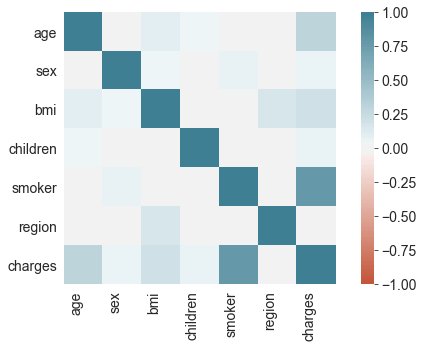

In [16]:
# Plotting the correlation matrix
corr = insurance.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

smoker shows high correlation with charges followed by age and then followed by bmi.

### Distribution of Smoker depending upon Sex of the patient

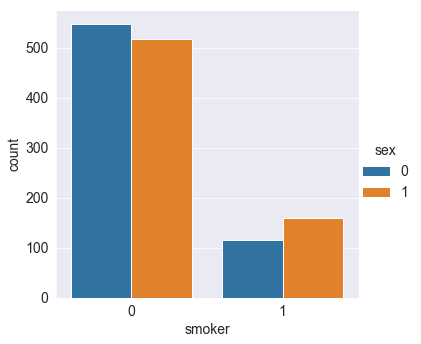

In [17]:
sns.catplot(x="smoker", kind="count",hue = 'sex', data=insurance)

### Distribution of Smoker depending upon the Age of the patient

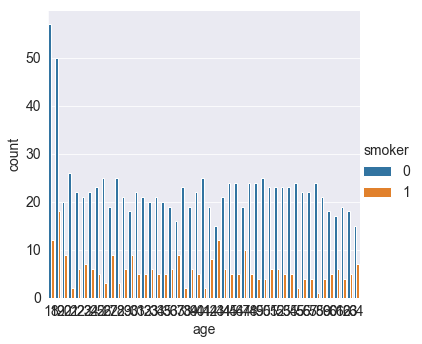

In [18]:
sns.catplot(x="age", kind="count",hue = 'smoker', data=insurance)

#### The above doesn't seem to be providing much information. So we will group the age column into age groups and then see the distribution

In [19]:
# Creating age groups
bins = (0, 18, 25, 40, 60, np.inf)  # The edges
labels = ('0-18', '19-25', '25-40', '41-60', '60 & above')
groups = pd.cut(insurance.age, bins=bins, labels=labels)

In [20]:
groups.value_counts()

41-60         546
25-40         395
19-25         237
60 & above     91
0-18           69
Name: age, dtype: int64

In [21]:
# Creating a dataframe of Age, Age_Group and Smoker
d = {'Age': insurance.age, 'Age_Group': groups, 'Smoker': insurance.smoker}
age_smoke = pd.DataFrame(data=d)
age_smoke.head()

,Age,Age_Group,Smoker
0,19,19-25,1
1,18,0-18,0
2,28,25-40,0
3,33,25-40,0
4,32,25-40,0


### Distribution of Smoker depending upon the Age Group of the pateint

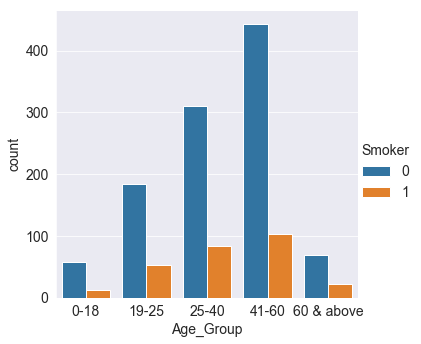

In [22]:
sns.catplot(x="Age_Group", kind="count",hue = 'Smoker', data=age_smoke)

Most of the smokers are in the age between 19 and 60 which makes sense.

C:\Program Files (x86)\Anaconda\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


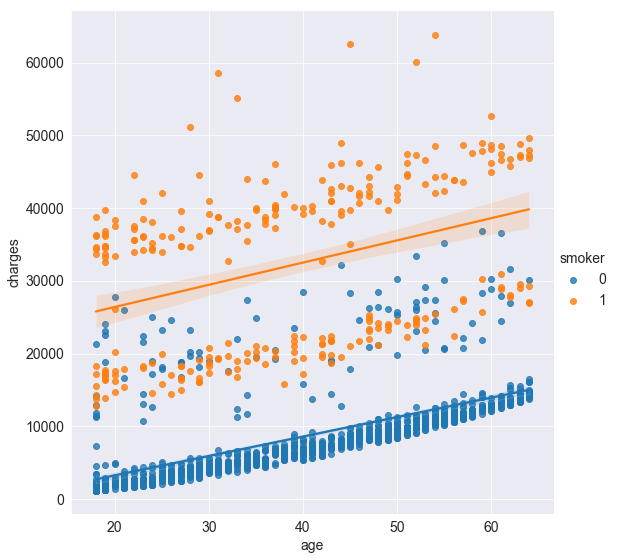

In [23]:
sns.lmplot(x="age", y="charges", hue="smoker", data=insurance, size=8)

As the age increases, the insurance charges also increase. But for Smokers it is very high. So, it is good not to smoke if you want to save your money.

## Modeling

In [24]:
X = insurance.drop(['charges'], axis = 1)
y = insurance.charges

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

### Linear Regression:

In [25]:
lr = LinearRegression().fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(round(lr.score(X_test,y_test)*100,2))
print(mean_absolute_error(y_test,y_test_pred))
print(mean_squared_error(y_test, y_test_pred))

79.63
3998.2715408869753
32073628.56010921


In [26]:
y_test_pred

array([10947.91401491,  9764.82733066, 38027.18625354, 16076.26656375,
        7003.05093861,  4162.38974052,  1745.17453352, 14273.5330135 ,
        9022.7490154 ,  7548.70107263,  4742.33662827, 10290.75344147,
        8592.56051588,  4173.37165612, 27970.0324915 , 11026.04778351,
       11286.00941429,  6197.06911697,  8269.51468144, 27263.01056172,
       33686.9512703 , 14247.8812616 , 11735.79293452, 32419.5578177 ,
        4475.57228648,  9264.65728706,  1336.5408973 , 10083.42064465,
        4134.01766875, 10422.0367284 ,  9033.04363126, 40177.36502272,
       15327.89185262, 13541.84076855, 24979.41529438,  5273.0794857 ,
       12809.44891047, 30538.99654744, 33503.98483751,  3477.84775709,
        4169.03343497,  4346.93367013, 30642.90398321, 39366.95813634,
       28066.36347631,  5110.98142166, 10919.49675465,  7870.63024919,
        3790.77872548, 10529.86942143,  5758.50260778,  3526.36470247,
       32837.53966438, 38431.60954739, 16119.53210068,  7198.88399648,
      

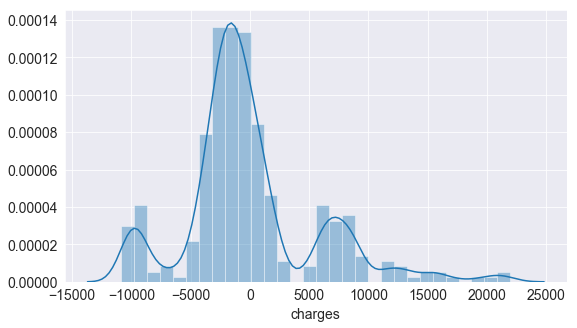

In [27]:
sns.distplot(y_test-y_test_pred)

#### Setting Hyperparameters for Decision Trees, Random Forest and XGBoost:

In [28]:
# Let's set number of trees:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
# Maximum features to be considered at every split:
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in each tree:
max_depth = [int(x) for x in np.linspace(start=5, stop=30, num=6)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5, 10]

In [29]:
from sklearn.model_selection import RandomizedSearchCV
# You can use GridSearchCV as well but RandomizedSearchCV is faster comparitively.

Let's create a parameter grid which we will further use in our Decision Trees, Random Forest and XGBoost model.

In [30]:
# Parameter grid for Decision Trees
tree_param_grid = { 
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

print(tree_param_grid)

{'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [31]:
# Parameter grid for Random Forest and XGBoost
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


### Decision Trees:

In [32]:
tree = DecisionTreeRegressor()

In [33]:
tree.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')>

In [34]:
tree_rand = RandomizedSearchCV(estimator=tree, param_distributions=tree_param_grid, n_jobs=1, n_iter=10, cv=5, verbose=2, 
                               random_state=0)
# , scoring='neg_mean_squared_error'

In [35]:
tree_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5 
[CV]  min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=5, total=   0.0s
[CV] min_samples_split=15, min_samples_leaf=1, max_features=log2, max_depth=20 
[CV]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   0.0s
[CV] min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   0.0s
[CV] min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   0.0s
[CV] min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  min_samples_split=2, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=10, max_features=log2, max_depth=10 
[CV]  min_samples_split=5, min_samples_leaf=10, max_features=log2, max_depth=10, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=10, max_features=log2, max_depth=10 
[CV]  min_samples_split=5, min_samples_leaf=10, max_features=log2, max_depth=10, total=   0.0s
[CV] min_samples_split=5, min_sample

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='d

In [36]:
tree_pred = tree_rand.predict(X_test)

In [37]:
tree_pred

array([11766.53423988,  9748.97790831, 41870.05126825, 13563.60712206,
       11345.42422859,  7084.42865772,  2932.55780661, 11345.42422859,
        7084.42865772,  7084.42865772,  7084.42865772, 11345.42422859,
        9748.97790831,  5148.30747506, 21781.75001625,  9748.97790831,
       14577.98736286,  4381.90483896,  7084.42865772, 33705.2506    ,
       24626.51984833, 14800.61554821, 11766.53423988, 30021.17661   ,
        2932.55780661,  7084.42865772,  7084.42865772,  7469.83892137,
        5148.30747506, 11345.42422859,  7084.42865772, 46538.79989182,
       13563.60712206, 11766.53423988, 18884.30504342,  7084.42865772,
        9748.97790831, 37994.74531   , 41870.05126825,  2932.55780661,
        7084.42865772,  5148.30747506, 18884.30504342, 46538.79989182,
       37994.74531   ,  8330.89141722,  9748.97790831,  7084.42865772,
        7084.42865772, 11766.53423988,  4381.90483896,  8330.89141722,
       30021.17661   , 46538.79989182, 11766.53423988,  7084.42865772,
      

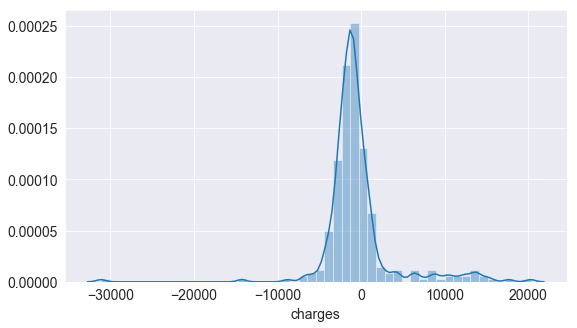

In [38]:
sns.distplot(y_test-tree_pred)

In [39]:
print(mean_squared_error(y_test, tree_pred))
print(round(tree_rand.score(X_test,y_test)*100,2))

18210684.57900789
88.43


### Random Forest:

In [40]:
rf = RandomForestRegressor()

In [41]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_jobs=1, n_iter=10, cv=5, verbose=2, 
                               random_state=0)
# , scoring='neg_mean_squared_error'

In [42]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   1.0s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   1.0s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   1.0s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   1.0s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   1.0s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=25, total=   4.1s
[CV] n_estimators=800, min_samples_split=2, m

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [43]:
rf_pred = rf_random.predict(X_test)

In [44]:
rf_pred

array([10955.17826747, 10475.51936001, 45861.71158171, 13979.1641012 ,
       10642.95894411,  7289.07672002,  2616.13032007, 13651.65030417,
        7696.25704218,  7478.37229694,  7965.90958332, 13933.92147035,
        8172.96820137,  5450.66751947, 19422.22814466, 12110.32109179,
       14237.87512493,  6358.19924855,  7249.71158505, 35321.51987515,
       24077.53692166, 15847.09315947, 11293.35757434, 27121.83895345,
        3485.70339102,  8582.82900095,  6003.8682157 ,  8014.03636525,
        4113.48230302, 10295.15578953,  7957.72672107, 47550.69221582,
       14035.80946486, 11353.91984436, 17454.79564578,  4868.9877759 ,
        9404.17050002, 38244.27547681, 40148.73226383,  3566.96208351,
        6953.93401743,  4278.86932009, 20038.85670986, 47326.80455659,
       38101.26405204,  6565.6706352 , 12174.74480206,  6952.27762469,
        6847.94038283, 12902.00367082,  4178.22826803,  6354.64095638,
       26932.56200059, 46597.15877596, 11545.69866667,  6922.75058516,
      

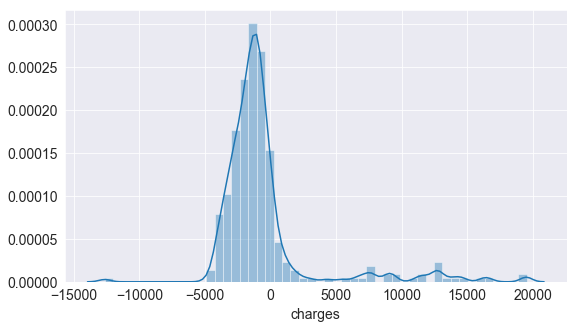

In [45]:
sns.distplot(y_test-rf_pred)

In [46]:
print(mean_squared_error(y_test, rf_pred))
print(round(rf_random.score(X_test,y_test)*100,2))

15434488.183168352
90.2


### XG Boost:

In [47]:
xg = xgb.XGBRegressor()

In [48]:
xg_rand = RandomizedSearchCV(estimator=xg, param_distributions=param_grid, n_jobs=1, n_iter=10, cv=5, verbose=2, 
                               random_state=0)
# , scoring='neg_mean_squared_error'

In [49]:
xg_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[22:25:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   1.8s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[22:25:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   1.6s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[22:25:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   1.7s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[22:25:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25, total=   1.4s
[CV] n_estimators=300, min_samples_split=15, min_samples_leaf=5, max_features=sqrt, max_depth=25 
[22:25:28] WARNING: C:/Jenkins/workspac

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          verbosity=1),
                   iid='deprecated', n_iter=10, n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 3

In [50]:
xg_pred = xg_rand.predict(X_test)

In [51]:
xg_pred

array([ 9416.495 ,  8676.233 , 44658.895 , 12695.504 ,  9168.524 ,
       15231.28  ,  2196.4841, 10104.1045,  6792.9536,  5659.1704,
        6504.048 , 23754.41  ,  7843.2334,  4531.416 , 32628.182 ,
       11836.265 , 12041.023 ,  7243.7734,  6243.8228, 34097.07  ,
       23104.834 , 14383.993 , 10584.995 , 27263.9   ,  7265.585 ,
       10185.9   ,  5989.8887,  9253.247 ,  3718.394 , 14563.403 ,
        7250.3384, 48673.527 , 20571.28  , 12475.582 , 15330.231 ,
        3947.4043,  9130.7   , 37698.457 , 39235.08  ,  2247.4976,
       11827.348 ,  2664.9011, 19324.09  , 47362.36  , 36434.914 ,
        3564.0647, 11845.342 ,  6341.1133,  4970.2344, 11438.388 ,
        3199.5852, 20348.945 , 27981.688 , 48621.812 , 11615.304 ,
       14871.1045,  2325.0178, 11723.487 ,  9265.221 , 12832.077 ,
        1313.8578, 45760.062 , 16187.128 ,  9908.29  , 10091.088 ,
        9319.608 , 34332.797 , 39013.414 ,  3102.3179,  8163.1406,
       13889.874 , 10731.355 , 16835.78  , 13949.965 , 13036.8

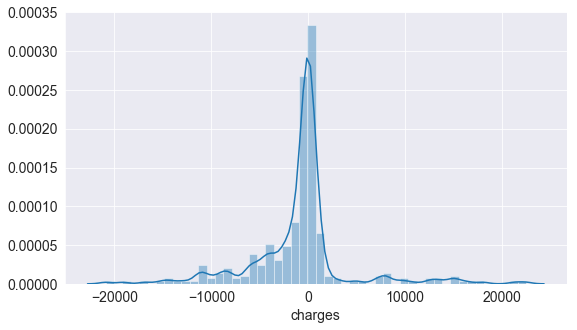

In [52]:
sns.distplot(y_test-xg_pred)

In [53]:
print(mean_squared_error(y_test, xg_pred))
print(round(xg_rand.score(X_test,y_test)*100,2))

27481781.796086952
82.54


As we can see that, **Random Forest with RandomizedSearchCV** gives us the **best accuracy**. So, we will select our best model as Random Forest in which the parameters are chosen by using RandomizedSearchCV.

In [54]:
import pickle

# Store the data of the best model in a file with .pkl exension
file = open('random_forest_regressor_model.pkl','wb')

# Now, dump info about your best model (Random Forest in our case) into the .pkl file
pickle.dump(rf_random, file)